In [1]:
import pandas as pd
import numpy as np
import hics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm

1_wHiCS: 10 datasets, each 100 independent features, 40 of them useful  
2_wRaR: 10 datasets, each 30 independent features, 20 of them useful, 70 dependent features  
3_wRaR: 10 datasets, each 100 independent features, 50 of them useful, 100 dependent features  
5_wrar: 1 dataset, 40 independent features, 25 of them useful, 20 dependent  
6_wrar: 3 datasets, 40 independent, 30 useful, 40 dependent  
7_wrar: 4 datasets, 40 independent, 30 useful, 40 dependent
9_wrar: 3 datasets, 70 independent, 70 useful, 30 dependent

In [2]:
data = pd.read_csv('../data/isolet.csv', header=None)
data[617] = data[617].astype(np.float32)
data.rename(columns=lambda c: str(c), inplace=True)
target = str(617)
# data

In [3]:
np.unique(data[target], return_counts=True)

(array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.,  24.,  25.,  26.], dtype=float32),
 array([240, 240, 240, 240, 240, 238, 240, 240, 240, 240, 240, 240, 240,
        240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240]))

In [4]:
# Artificially imbalance dataset
class0 = data.loc[data[target] == 3]
class1 = data.loc[data[target] == 7]
class2 = data.loc[data[target] == 1]
subset = [class0.sample(frac=0.2), class1.sample(frac=0.1), class2.sample(frac=1),
          data.loc[(data[target] != 3) & (data[target] != 7) & (data[target] < 8)]]
imb_data = pd.concat(subset).reset_index(drop=True)

In [5]:
np.unique(imb_data[target], return_counts=True)[1]

array([480, 240,  48, 240, 240, 238,  24])

In [6]:
data = imb_data

In [ ]:
import csrar

rar = csrar.rar.RaR(data)
rar.run(target, k=5, runs=500, split_iterations=20, compensate_imbalance=True)

rar_nocomp = csrar.rar.RaR(data)
rar_nocomp.run(target, k=5, runs=500, split_iterations=20, compensate_imbalance=False)

Generated cost matrix:
        1.0       2.0        3.0       4.0       5.0       6.0        7.0
0  3.145833  6.291667  31.458333  6.291667  6.291667  6.344538  62.916667
Overall cost matrix:
        1.0       2.0        3.0       4.0       5.0       6.0        7.0
0  3.145833  6.291667  31.458333  6.291667  6.291667  6.344538  62.916667
Relevance: 100.00%    
Running optimizer...
Optimizer done.
defaultdict(<class 'int'>, {'511': 2.8938513289033965e-08, '228': 0.027761611129847107, '297': 9.3854427568199223e-11, '135': 0.056975308862235119, '70': 0.045714013463919609, '23': 0.018930466204007779, '457': 0.62929864238105571, '107': 0.12148574841410514, '54': 9.2390586134306763e-11, '319': 9.2379194247515492e-11, '431': 9.3110728629607369e-11, '583': 9.2389609939187864e-11, '300': 0.092513515389345838, '51': 1.1449658627899588e-10, '541': 0.0036854108195159925, '189': 0.042657982831815953, '507': 0.0015724936136212481, '501': 0.028581554469565, '600': 0.0071187053689665703, '111': 9.2405

Redundancy: 5.67%     

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC

# Train/Test split
X = data.drop(target, axis=1)
y = data[target]

# nm = NearMiss(random_state=45622)
# X_res, y_res = nm.fit_sample(X, y)

# X = pd.DataFrame(X_res, columns=X.columns)
# y = y_res

probs = np.unique(y, return_counts=True)[1] / len(y)

max_k = 230
scores = pd.DataFrame(columns=['wRaR', 'RaR'], index=np.arange(1, max_k + 1)).fillna(0)

rank_columns_nocomp = [r[0] for r in rar_nocomp.feature_ranking]
from sklearn.metrics import f1_score
for k in range(1, max_k + 1):
    # clf = LinearSVC(class_weight='balanced')
    clf = KNeighborsClassifier(n_neighbors=5)
#     clf = GaussianNB()
    f1_macros = cross_val_score(clf, X[rank_columns_nocomp[:k]], y, cv=3, scoring='accuracy')
    scores.loc[k, 'RaR'] = np.mean(f1_macros)

    # clf.fit(X_train[rank_columns_nocomp[:k]], y_train)
    # y_predict_ideal = clf.predict(X_test[rank_columns_nocomp[:k]])
    # score = f1_score(y_test, y_predict_ideal, average='macro')
    # scores.loc[k, 'RaR'] += score
    # for i, s in enumerate(score):
    #    scores.loc[k, 'RaR' + str(i)] += s

rank_columns = [r[0] for r in rar.feature_ranking]
for k in range(1, max_k + 1):
    # clf_selected = LinearSVC(class_weight='balanced')
    clf_selected = KNeighborsClassifier(n_neighbors=5)
#     clf_selected = GaussianNB()
    f1_macros = cross_val_score(clf_selected, X[rank_columns[:k]], y, cv=3, scoring='accuracy')
    scores.loc[k, 'wRaR'] = np.mean(f1_macros)
    
    # clf_selected.fit(X_train[rank_columns[:k]], y_train)
    # y_predict = clf_selected.predict(X_test[rank_columns[:k]])
    # score = f1_score(y_test, y_predict, average='macro')
    # scores.loc[k, 'wRaR'] += score
    # for i, s in enumerate(score):
    #    scores.loc[k, 'wRaR' + str(i)] += s

# scores.to_csv('final2_wRaR_isolet_5nn_3cv_600.csv')
scores

,wRaR,RaR
1,0.423175,0.462248
2,0.482782,0.598699
3,0.515890,0.585440
4,0.584101,0.594704
5,0.584770,0.586769
6,0.588743,0.607290
7,0.586102,0.629810
8,0.609945,0.658944
9,0.666228,0.653642
10,0.687424,0.645045


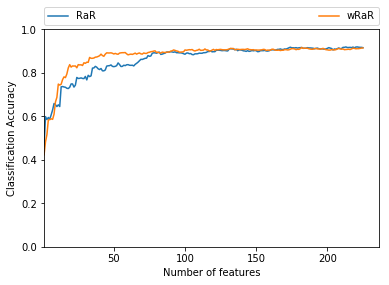

In [46]:
import matplotlib.pyplot as plt
plt.plot(scores['RaR'][:225], label='RaR')
plt.plot(scores['wRaR'][:225], label='wRaR')
ax = plt.gca()
ax.set_xlabel('Number of features')
ax.set_ylabel(r'Classification Accuracy')
ax.set_ylim([0.0, 1.0])
ax.set_xlim(1)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('final2_wRaR_isolet_5nn_3cv_best225_acc')
plt.show()

In [26]:
scores['wRaR'][scores['wRaR'] > 0.89]

110    0.891066
114    0.894806
119    0.892772
120    0.895614
122    0.891156
123    0.890156
124    0.891251
181    0.894271
182    0.902351
183    0.895722
184    0.896239
185    0.896269
186    0.896202
187    0.898176
188    0.897105
189    0.892461
190    0.892461
218    0.908900
219    0.904464
220    0.902780
221    0.903406
222    0.903030
223    0.911330
224    0.912446
225    0.916479
226    0.912476
227    0.904425
228    0.904356
229    0.905577
230    0.905788
         ...   
562    0.891175
572    0.890062
573    0.890616
574    0.891194
575    0.891194
576    0.891194
577    0.891716
578    0.891754
579    0.891565
580    0.892260
581    0.893466
582    0.893466
583    0.894495
584    0.895554
585    0.895061
586    0.891527
587    0.891527
588    0.892117
589    0.893779
590    0.893170
591    0.894941
592    0.896269
593    0.894483
594    0.895069
595    0.894920
596    0.895528
597    0.893856
598    0.894430
599    0.894430
600    0.895630
Name: wRaR, Length: 358,

In [27]:
clf_all = KNeighborsClassifier(n_neighbors=5)
f1_macros = cross_val_score(clf_all, X, y, cv=3, scoring='f1_macro')
np.mean(f1_macros)

0.8905419567526508

In [ ]:
scores

## Ground truth

In [ ]:
# For test7.arff
weights = [0.5335601544927123, 0.759839177764759, 0.772151052808685, 0.7625265610410171,
           0.5612073314384326, 0.34594353279215817, 0.26778115186982904, 0.05104168604756121,
           0.24539066769327755, 0.4298986108981449, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=input_features, index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
# For test8.arff
weights = [0.5335601544927123, 0.759839177764759, 0.772151052808685, 0.7625265610410171,
           0.5612073314384326, 0.34594353279215817, 0.26778115186982904, 0.05104168604756121,
           0.24539066769327755, 0.4298986108981449, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=data.columns[:20], index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
# For test9.arff
weights = [0.7168886878437233, 0.1650913157879492, 0.7017219042598103, 0.5371651431980248,
           0.4012494719087343, 0.08997742462568355, 0.4133240085774441, 0.3003377473503873,
           0.12858013417222078, 0.5857996257919974, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=data.columns[:20], index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
# For test10.arff
weights = [0.2673055187472877, 0.196159223714542, 0.701161636883324, 0.765385125610722,
           0.0011260947105074194, 0.22801651296579062, 0.8949526553930152, 0.13072480437597472,
           0.6333889311003507, 0.7420344156127076, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
           0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
           0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
           0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=data.columns[:70], index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
ideal_ranking = ground_truth.sort_values(0, axis=1, ascending=False).columns

In [ ]:
import arff
file = open('../data/5_wrar.arff', 'r')
dataset = arff.load(file)
data = pd.DataFrame(dataset['data'])
data[60] = data[60].astype(np.float32)
data.rename(columns=lambda c: str(c), inplace=True)
target = str(60)

## Compensating HiCS

In [ ]:
import arff
datas = []
for i in range(1, 4):
    file = open('../data/9_wrar/9_wrar_' + str(i) + '.arff', 'r')
    dataset = arff.load(file)
    file.close()
    data = pd.DataFrame(dataset['data'])
    data[100] = data[100].astype(np.float32)
    data.rename(columns=lambda c: str(c), inplace=True)
    datas.append(data)
target = str(100)

## Standard HiCS

## Testing classifier

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_res, y_res = rus.fit_sample(X_train, y_train)
X_res = pd.DataFrame(X_res, columns=X_train.columns)
# y_res = pd.DataFrame(y_res, columns=[20])

In [ ]:
counts/len(datas[0])

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

values, counts = np.unique(datas[0][target], return_counts=True)
marg = ax.bar(np.arange(5), counts/len(datas[0]), 0.35, color='green')
cond = ax.bar(np.arange(5) + 0.35, [0.03, 0.05, 0.7, 0.07, 0.15], 0.35, color='orange')
# ax.bar(np.arange(5), counts/len(data), 0.35, color='green')

ax.set_ylabel('Probability')
ax.set_xlabel('Class')
ax.set_title('Marginal and conditional probabilities')
ax.set_xticks(np.arange(5) + 0.35 / 2)
ax.set_xticklabels(('$c_1$', '$c_2$', '$c_3$', '$c_4$', '$c_5$'))
ax.set_ylim([0, 1])

ax.legend((marg, cond), ('Marginal distribution', 'Conditional distribution'))
plt.savefig('marg_cond')

plt.show()

In [ ]:
import warnings
warnings.filterwarnings("default")

In [ ]:
scores

In [ ]:
for data in datas:
    values, counts = np.unique(data[target], return_counts=True)
    print(counts/len(data))

In [ ]:
columns[:3]

In [ ]:
k = 15
results_nocomp = []
rank_columns_nocomp = [r[0] for r in rar_nocomp.feature_ranking]
from sklearn.metrics import f1_score
for j in range(25):
    clf = RandomForestClassifier()
    clf.fit(X_train[rank_columns_nocomp[:k]], y_train)
    y_predict_ideal = clf.predict(X_test[rank_columns_nocomp[:k]])
    results_nocomp.append(f1_score(y_test, y_predict_ideal, average='macro'))

results = []
rank_columns = [r[0] for r in rar.feature_ranking]
for j in range(25):
    clf_selected = RandomForestClassifier()
    clf_selected.fit(X_train[rank_columns[:k]], y_train)
    y_predict = clf_selected.predict(X_test[rank_columns[:k]])
    results.append(f1_score(y_test, y_predict, average='macro'))

print('Dataset 1_whics_' + str(i+1))#, file=log)
print('Weighted RaR macro-weighted F1: ' + str(np.mean(results)))#, file=log)
print('Standard RaR macro-weighted F1: ' + str(np.mean(results_nocomp)))#, file=log)
print('Difference weighted-standard: ' + str(np.mean(results) - np.mean(results_nocomp)))#, file=log)

## Cumulative Gain

In [ ]:
ideal_CG = [ground_truth.loc[0, ideal_ranking[:i].values].sum()
            for i in range(len(ideal_ranking))]
CG = [ground_truth.loc[0, [r for r in rank_columns[:i]]].sum()
      for i in range(len(rank_columns))]
nocomp_CG = [ground_truth.loc[0, [r for r in rank_columns_nocomp[:i]]].sum()
             for i in range(len(rank_columns_nocomp))]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(CG, label='Cumulative Gain Compensating HiCS')
plt.plot(nocomp_CG, label='Cumulative Gain Standard HiCS')
plt.plot(ideal_CG, label='Ideal gain')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
# plt.savefig('HiCS_test7_comp_imb2_CG_weightmod1-8')
plt.show()

## Rankings

In [ ]:
rank_columns_nocomp

In [ ]:
rank_columns

In [ ]:
ideal_ranking

In [ ]:
log = open('binary_wHiCS_log.txt', 'w')
for i, data in enumerate(datas):
    # Compensating HiCS
    #
    #
    values, counts = np.unique(data[target], return_counts=True)
    cost_matrix = pd.DataFrame(columns=values)
    for value, count in zip(values, counts):
        weighting = (len(data) / count)
        cost_matrix[value] = [weighting]
    cost_matrix = cost_matrix
    cost_matrix

    from hics.result_storage import DefaultResultStorage
    input_features = [ft for ft in data.columns.values if ft != target]
    storage = DefaultResultStorage(input_features)

    from hics.incremental_correlation import IncrementalCorrelation
    correlation = IncrementalCorrelation(data, target, storage,
                                         iterations=50, alpha=0.1,
                                         drop_discrete=False, cost_matrix=cost_matrix)

    correlation.update_bivariate_relevancies(runs=5)

    ranking = storage.get_relevancies().relevancy.sort_values(ascending=False)
    rank_columns = [tup[0] for tup in ranking.index.values]

    # Standard HiCS
    #
    #
    input_features = [ft for ft in data.columns.values if ft != target]
    storage_nocomp = DefaultResultStorage(input_features)
    correlation_nocomp = IncrementalCorrelation(data, target, storage_nocomp,
                                                iterations=50, alpha=0.1,
                                                drop_discrete=False, cost_matrix=None)

    correlation_nocomp.update_bivariate_relevancies(runs=5)

    ranking_nocomp = storage_nocomp.get_relevancies(
    ).relevancy.sort_values(ascending=False)
    rank_columns_nocomp = [tup[0] for tup in ranking_nocomp.index.values]

    # Train/Test split
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Test Classifier
    #
    #
    k = 10
    results_nocomp = []
    from sklearn.metrics import f1_score
    for j in range(100):
        clf = RandomForestClassifier()
        clf.fit(X_train[rank_columns_nocomp[:k]], y_train)
        y_predict_ideal = clf.predict(X_test[rank_columns_nocomp[:k]])
        results_nocomp.append(
            f1_score(y_test, y_predict_ideal, average='macro'))

    results = []
    for j in range(100):
        clf_selected = RandomForestClassifier()
        clf_selected.fit(X_train[rank_columns[:k]], y_train)
        y_predict = clf_selected.predict(X_test[rank_columns[:k]])
        results.append(f1_score(y_test, y_predict, average='macro'))
    
    print('Dataset 1_whics_' + str(i+1), file=log)
    print('Weighted RaR macro-weighted F1: ' + str(np.mean(results)), file=log)
    print('Standard RaR macro-weighted F1: ' + str(np.mean(results_nocomp)), file=log)
    print('Difference weighted-standard: ' + str(np.mean(results) - np.mean(results_nocomp)), file=log)
    log.flush()

In [ ]:
import csrar
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict

max_k = 50
classes = np.arange(len(np.unique(datas[0][target])))
columns = ['RaR' + str(i) for i in classes] + ['wRaR' + str(i) for i in classes]
scores = pd.DataFrame(columns=columns, index=np.arange(1,max_k+1)).fillna(0)

for data in datas:
    # Compensating RaR
    #
    #
    rar = csrar.rar.RaR(data)
    rar.run(target, k=5, runs=200, split_iterations=10, compensate_imbalance=True)

    # Standard RaR
    #
    #
    rar_nocomp = csrar.rar.RaR(data)
    rar_nocomp.run(target, k=5, runs=200, split_iterations=10, compensate_imbalance=False)

    # Train/Test split
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Test Classifier
    #
    #
    rank_columns_nocomp = [r[0] for r in rar_nocomp.feature_ranking]
    from sklearn.metrics import f1_score
    for k in range(1, max_k+1):
        clf = GaussianNB()
        clf.fit(X_train[rank_columns_nocomp[:k]], y_train)
        y_predict_ideal = clf.predict(X_test[rank_columns_nocomp[:k]])
        score = f1_score(y_test, y_predict_ideal, average='macro')
        scores.loc[k, 'RaR'] += score
        for i, s in enumerate(score):
            scores.loc[k, 'RaR' + str(i)] += s
        
    rank_columns = [r[0] for r in rar.feature_ranking]
    for k in range(1, max_k+1):
        clf_selected = GaussianNB()
        clf_selected.fit(X_train[rank_columns[:k]], y_train)
        y_predict = clf_selected.predict(X_test[rank_columns[:k]])
        score = f1_score(y_test, y_predict, average='macro')
        scores.loc[k, 'wRaR'] += score
        for i, s in enumerate(score):
            scores.loc[k, 'wRaR' + str(i)] += s

scores /= len(datas)
scores.to_csv('final_wRaR_3wrar_nb.csv')
scores

In [ ]:
def gini(array):
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)
    array += 0.0000001
    array = np.sort(array)
    index = np.arange(1,array.shape[0]+1)
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))